# Model Training, Evaluation and Selection

This notebook does the following:

* Loads the MNIST and Kaggle AZ Datasets
* Trains a KNN classifier and a ResNet Classifier
* Tests accuracy of the above

### Dependencies

In [15]:
# import the necessary packages
from tensorflow.keras.datasets import mnist
import numpy as np
from tensorflow.python.client import device_lib 
print(device_lib.list_local_devices())
from tensorflow.compat.v1 import ConfigProto
from tensorflow.compat.v1 import InteractiveSession
config = ConfigProto()
config.gpu_options.allow_growth = True
session = InteractiveSession(config=config)
az_dataset_path = r"C:\GitHub\mf724-ocr\az-dataset\A_Z Handwritten Data.csv"
import pandas as pd
from matplotlib import pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
import time
from tensorflow.keras.applications.resnet50 import ResNet50
import cv2
import warnings
warnings.filterwarnings('ignore')
from sklearn.metrics import classification_report
import tensorflow
tensorflow.autograph.experimental.do_not_convert(func=None)

[name: "/device:CPU:0"
device_type: "CPU"
memory_limit: 268435456
locality {
}
incarnation: 14123534073417642930
, name: "/device:GPU:0"
device_type: "GPU"
memory_limit: 4153868288
locality {
  bus_id: 1
  links {
  }
}
incarnation: 17105257790114846871
physical_device_desc: "device: 0, name: NVIDIA GeForce RTX 2060, pci bus id: 0000:01:00.0, compute capability: 7.5"
]


<function tensorflow.python.autograph.impl.api.do_not_convert(func=None)>

### Create Labels for combined Dataset

In [16]:
labels = "0123456789abcdefghijklmnopqrstuvwxyz"
dataset_labels = []
for i in labels:
    dataset_labels.append(i)

print(dataset_labels)

['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 'a', 'b', 'c', 'd', 'e', 'f', 'g', 'h', 'i', 'j', 'k', 'l', 'm', 'n', 'o', 'p', 'q', 'r', 's', 't', 'u', 'v', 'w', 'x', 'y', 'z']


### Datasets

Loads the MNIST and AZ datasets, then combines and splits them for training/validation

Label: 5


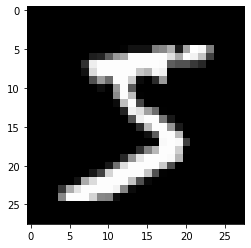

In [17]:
#extract mnist data as per api
(train_X, train_y), (test_X, test_y) = mnist.load_data()
#combine all labels and images so we can split  later
mn_images = np.vstack([train_X, test_X])
mn_labels = np.hstack([train_y, test_y])
MN = (mn_labels, mn_images)

#test image to show data is loaded correctly
print("Label:", MN[0][0])
plt.imshow(MN[1][0], cmap="gray")

Label: a


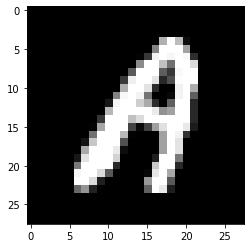

In [18]:
#load az dataset from local path
df = pd.read_csv(az_dataset_path)

#empty lists to fill with images and labels
az_images = []
az_labels = []

#iterate through dataset extracting label and images
for index, row in df.iterrows():
    #row 0 contains the label
    label = row["0"]
    #all other row contents are the images
    image = np.array(row[1:], dtype="uint8")
    #rearrange the array to an image format
    image = image.reshape((28, 28))
    az_images.append(image)
    #we add 10 as the labels will be after the 0-9 labels
    az_labels.append(label+10)

#load images and labels into single arrays of correct format
az_images = np.array(az_images, dtype="float32")
az_labels = np.array(az_labels, dtype="int")
#create a tuple for AZ data
AZ = (az_labels, az_images)
#show a test image to prove correct loading
plt.imshow(AZ[1][0], cmap="gray")
print("Label:", dataset_labels[AZ[0][1]])

### Split Datasets

In [19]:
#create a single image and label dataset from both datasets
comb_images = np.vstack([MN[1], AZ[1]])
comb_labels = np.hstack([MN[0], AZ[0]])

#flatten images for knn model
flat_images = [x.flatten() for x in comb_images]
#split test sets for KNN
ktrainX, ktestX, ktrainY, ktestY = train_test_split(flat_images, comb_labels, test_size=0.25, random_state=1)

#resnet requires images be a minimum of 32, 32, 1
#therefore we need to resize them accordingly
comb_images = [cv2.resize(image, (32, 32)) for image in comb_images]
comb_images = np.array(comb_images, dtype="float32")

#now we need to add the x,x,1 and normalise the values to be between 0 and 1
comb_images = np.expand_dims(comb_images, axis=-1)
comb_images /= 255.0

#split test sets for CNN, using same randomstate to ensure no bias
trainX, testX, trainY, testY = train_test_split(comb_images, comb_labels, test_size=0.25, random_state=1)

### ResNet

In [20]:
#instantiate the resnet model with randomised weights, input shape and amount of classes
model = ResNet50(weights=None, input_shape=(32, 32, 1), classes=len(dataset_labels))

#compile model
model.compile(loss="sparse_categorical_crossentropy", optimizer='adam', metrics=["accuracy"])

#train model on training data, using 10% for validation
#batch size uses ~90% of a GTX 1080 TI
startTime = time.time()
model.fit(trainX, trainY, batch_size=128, epochs=1, validation_split=0.1, verbose=1)
print("Fitting time:", time.time()-startTime)

#carry out predictions
startTime = time.time()
preds = model.predict(testX)
print("Predictions time:", time.time()-startTime)

#print a classification report to see final scores
print(classification_report(testY, preds.argmax(axis=1), target_names=dataset_labels))

#save the model
model.save("C:\GitHub\mf724-ocr\ResNet50")

2334/2334 [==============================] - 184s 76ms/step - loss: 0.3818 - accuracy: 0.9010 - val_loss: 0.1836 - val_accuracy: 0.9470
Fitting time: 184.21516108512878
Predictions time: 41.882609367370605
              precision    recall  f1-score   support

           0       0.82      0.63      0.71      1721
           1       0.96      0.99      0.98      1919
           2       0.95      0.83      0.89      1763
           3       0.86      0.95      0.90      1765
           4       0.96      0.91      0.93      1724
           5       0.89      0.85      0.87      1632
           6       0.95      0.98      0.97      1764
           7       0.83      0.99      0.91      1772
           8       0.97      0.81      0.88      1725
           9       0.94      0.93      0.94      1726
           a       0.98      0.92      0.95      3473
           b       0.93      0.94      0.93      2199
           c       0.91      0.99      0.95      5821
           d       0.90      0.95    

### KNN Classifier

In [34]:
#instantiate a KNN classifier
knn = KNeighborsClassifier(len(dataset_labels), n_jobs=-1)

#monitor time taken to train and predict
startTime = time.time()
knn.fit(ktrainX, ktrainY)
print("Fitting time:", time.time()-startTime)

#predict on validation data
startTime = time.time()
preds = knn.predict(ktestX)
print("Predictions time:", time.time()-startTime)
print(classification_report(ktestY, preds, target_names=dataset_labels))

knn.save("C:\GitHub\mf724-ocr\KNN")

Fitting time: 1088.7480635643005


ValueError: Expected 2D array, got 1D array instead:
array=[28 34 27 ... 28  3  6].
Reshape your data either using array.reshape(-1, 1) if your data has a single feature or array.reshape(1, -1) if it contains a single sample.

# Final Results:

### ResNet50:

Weigted AVG F1 Score 0.96
Training Time 139 seconds
Full Prediction Time 33 seconds
Single Prediction Time 0.0003 seconds

### KNN

Weigted AVG F1 Score 0.91
Training Time 1088 seconds
Full Prediction Time 7267 seconds
Single Prediction Time 0.07 seconds

The ResNet50 model out performs the KNN model in every metric, and will be used as the final model.